# Open Ocean
# Open Earth Fundation
---------------------------------------------------------------------------------------------------------------------
Authors: Margaux Filippi & Maureen Fonseca

---------------------------------------------------------------------------------------------------------------------

<h1> Step 2: calculate different metrics for each modulating factor </h1>
    
This notebook is the second part of the Step1_Curate_IUCN_RedList.ipynb

<h2> Modulating Factor 3.1: Endemic Species  <h2>

<h2> Data needed for this project </h2>

The data was output by `Step1_Curate_IUCN_RedList.ipynb` and can be found under [IUCN_RedList](https://drive.google.com/drive/folders/1waEAtfQwErhBKH3GkTHZXIlbadzH3HYu?usp=share_link) under a temporary folder that accompagnies the GitHub repository: 

`Ocean Program > data > data_processed > ACMC_IUCN_RedList`

### Analyzing UICN data for marine species in the Eastern Tropical Pacific.

In [1]:
import geopandas as gpd

/Users/maureenfonseca/opt/anaconda3/lib/python3.9/site-packages/geopandas/_compat.py:111: UserWarning: The Shapely GEOS version (3.8.0-CAPI-1.13.1 ) is incompatible with the GEOS version PyGEOS was compiled with (3.10.1-CAPI-1.16.0). Conversions between both will be slow.
  warnings.warn(


In [2]:
import numpy as np
import pandas as pd

In [3]:
import os
import glob

In [4]:
from shapely.geometry import Polygon, Point

In [5]:
import fiona; #help(fiona.open)

In [6]:
import matplotlib.pyplot as plt
import seaborn as sns

In [7]:
import timeit

In [129]:
from netCDF4 import Dataset
import cmocean
import geopandas as gpd
from matplotlib.ticker import LinearLocator
from mpl_toolkits.axes_grid1 import make_axes_locatable

OEF functions

In [8]:
from marinebiodiversity_utils import *

<h1> 2.1. Load data </h1>

<h2> 2.1.1 Get the conservation area</h2>

Mostly for plotting.

<h3> Coordinates for Cocos Island </h3>

Cocos Island is located at 05°31′41″N; 87°03′40″W

In [9]:
Cocos_lat = 5+31/60+41/3600
Cocos_lon = -(87+3/60+40/3600)
Cocos = Point(Cocos_lon, Cocos_lat)

<h3> Import entire AMMB and PNIC </h3>

In [10]:
ACMC = gpd.read_file('../../Geospatial_ACMC/ACMC.shp')
AMMB = gpd.read_file('../../Geospatial_ACMC/AMMB.shp')
PNIC = gpd.read_file('../../Geospatial_ACMC/PNIC.shp')

Inspect the Coordinate Reference Systems (CRS).

In [11]:
AMMB.crs

<Derived Projected CRS: EPSG:5367>
Name: CR05 / CRTM05
Axis Info [cartesian]:
- N[north]: Northing (metre)
- E[east]: Easting (metre)
Area of Use:
- name: Costa Rica - onshore and offshore east of 86°30'W.
- bounds: (-86.5, 2.21, -81.43, 11.77)
Coordinate Operation:
- name: Costa Rica TM 2005
- method: Transverse Mercator
Datum: Costa Rica 2005
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

In [1]:
PNIC.crs

NameError: name 'PNIC' is not defined

In [13]:
AMMB_WGS84 = AMMB.to_crs(crs=4326)
PNIC_WGS84 = PNIC.to_crs(crs=4326)
ACMC = ACMC.set_crs(epsg=4326, allow_override=True)

In [14]:
ACMC['area']

0    1.062837e+07
Name: area, dtype: float64

Get area information.

In [15]:
print("Area, PNIC:")
print("{:0.2f}".format(PNIC_WGS84.area.item()) + " sqdeg.")
print("{:,.2f}".format(PNIC_WGS84.to_crs(crs=31970).area.item()*10**(-6)) + " sqkm in CRS 31970.")

print("\nArea, AMMB:")
print("{:0.2f}".format(AMMB_WGS84.area.item()) + " sqdeg.")
print("{:,.2f}".format(AMMB_WGS84.to_crs(crs=31970).area.item()*10**(-6)) + " sqkm in CRS 31970.")

print("\nTotal Area, ACMC:")
print("{:0.2f}".format(AMMB_WGS84.area.item() + PNIC_WGS84.area.item()) + " sqdeg.")
print("{:,.2f}".format(AMMB_WGS84.to_crs(crs=31970).area.item()*10**(-6) + PNIC_WGS84.to_crs(crs=31970).area.item()*10**(-6)) + " sqkm in CRS 31970.")

Area, PNIC:
4.47 sqdeg.
54,799.50 sqkm in CRS 31970.

Area, AMMB:
8.66 sqdeg.
106,243.90 sqkm in CRS 31970.

Total Area, ACMC:
13.13 sqdeg.
161,043.41 sqkm in CRS 31970.


/var/folders/v8/b0fnjf9d4q31sfz_8q4h4zxm0000gn/T/ipykernel_9053/2915868912.py:2: UserWarning: Geometry is in a geographic CRS. Results from 'area' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  print("{:0.2f}".format(PNIC_WGS84.area.item()) + " sqdeg.")
/var/folders/v8/b0fnjf9d4q31sfz_8q4h4zxm0000gn/T/ipykernel_9053/2915868912.py:6: UserWarning: Geometry is in a geographic CRS. Results from 'area' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  print("{:0.2f}".format(AMMB_WGS84.area.item()) + " sqdeg.")
/var/folders/v8/b0fnjf9d4q31sfz_8q4h4zxm0000gn/T/ipykernel_9053/2915868912.py:10: UserWarning: Geometry is in a geographic CRS. Results from 'area' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  print("{:0.2f}".format(AMMB_WGS84.area.item() + PNIC_WGS84.area.item()) + " sqdeg.")


<h2> 2.1.2 Get the species data </h2>

This is the outcome from `Step1_Curate_IUCN_RedList.ipynb`.

In [16]:
df = gpd.read_file('../../ACMC_IUCN_data/gdf_ACMC_IUCN_range_status_filtered.shp') 

In [17]:
df.head()

,index,ASSESSMENT,ID_NO,BINOMIAL,PRESENCE,ORIGIN,SEASONAL,COMPILER,YEAR,CITATION,LEGEND,SUBSPECIES,SUBPOP,DIST_COMM,ISLAND,TAX_COMM,redlistCat,scientific,geometry
0,3,1506081,177969.0,Acanthurus nigricans,1,1,1,Jonnell Sanciangco,2010,International Union for Conservation of Nature...,Extant (resident),None,None,None,None,None,Least Concern,Acanthurus nigricans,"MULTIPOLYGON (((109.79501 6.13966, 109.89836 6..."
1,10,1512439,177988.0,Naso annulatus,1,1,1,Jonnell Sanciangco,2010,International Union for Conservation of Nature...,Extant (resident),None,None,None,None,None,Least Concern,Naso annulatus,"MULTIPOLYGON (((109.79501 6.13966, 109.89836 6..."
2,13,1517273,178002.0,Naso hexacanthus,1,1,1,Jonnell Sanciangco,2010,International Union for Conservation of Nature...,Extant (resident),None,None,None,None,None,Least Concern,Naso hexacanthus,"MULTIPOLYGON (((99.07516 7.94581, 99.07794 7.9..."
3,97,2412930,195754.0,Gymnothorax meleagris,1,1,1,IUCN Marine Biodiversity Unit/GMSA,2018,IUCN Marine Biodiversity Unit/GMSA,Extant (resident),None,None,None,None,None,Least Concern,Gymnothorax meleagris,"MULTIPOLYGON (((144.23853 -3.82053, 144.24330 ..."
4,102,2423479,195824.0,Uropterygius macrocephalus,1,1,1,IUCN Marine Biodiversity Unit/GMSA,2018,IUCN Marine Biodiversity Unit/GMSA,Extant (resident),None,None,None,None,None,Least Concern,Uropterygius macrocephalus,"MULTIPOLYGON (((144.23853 -3.82053, 144.24330 ..."


With the first version data from Margaux, the data set had 164 unique species, now:

In [20]:
print("There are " + str(len(df)) + " unique species in this dataset.")

There are 640 unique species in this dataset.


In [22]:
print("The columns are:")
print(df.columns)

The columns are:
Index(['index', 'ASSESSMENT', 'ID_NO', 'BINOMIAL', 'PRESENCE', 'ORIGIN',
       'SEASONAL', 'COMPILER', 'YEAR', 'CITATION', 'LEGEND', 'SUBSPECIES',
       'SUBPOP', 'DIST_COMM', 'ISLAND', 'TAX_COMM', 'redlistCat', 'scientific',
       'geometry'],
      dtype='object')


Super annoying ESRI note: the column headers are cropped to 10 characters.

`redlistCat` = `redlistCategory`

`scientific` = `scientificName`

<h1> 2. Preliminary calculations </h1> 

In [27]:
area_of_conservation = ACMC.geometry.item()

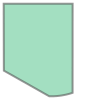

In [28]:
area_of_conservation

Note: Maybe this modulating factor can have another name, because we can obtain more information from it, as local species or migratory species.

Let's to define a distribution ratio based on the distribution area within total conservation area and the total distribution area for each species:

DistRatio 2 = $\frac{\text{distribution area within total conservation area}}{\text{total distribution area}}$

Here we can have 3 scenarios:

1. `Distribution Ratio 2 > 1`:This makes no sense because its implies that the distribution area within total conservation area is biggest that its total distribution area
2. `Distribution Ratio 2 = 1`: This implies that those species are endemic and their distribution total area is the same of the ACMC
3. `Distribution Ratio 2 < 1`: 

    3.1 When Distribution `Ratio 2 is close to 1`: This means that those species don't are endemic of ACMC but they could be local species (East Central Pacific, e.g)
    
    3.2 When Distribution `Ratio 2 << 1`: 1. Those species are migratory, they visit ACMC seasonally and can travel long distance. 2. You can find them in other parts of the ocean around the world.

Maps examples: https://towardsdatascience.com/plot-choropleth-maps-with-shapefiles-using-geopandas-a6bf6ade0a49
https://stackoverflow.com/questions/65507374/plotting-a-geopandas-dataframe-using-plotly

In [50]:
# Make new columns
df["DistRatio2"] = 0
df["DistFactorPerc2"] = 0
DistRatio2 = []
DistFactorPerc2 = []

#Method 1:

for iter, row in df.iterrows():
    
    df_intersect = df[df.BINOMIAL==row.BINOMIAL].intersection(area_of_conservation)
    ratio2 = (df_intersect.area/df[df.BINOMIAL==row.BINOMIAL].area).sum()

    DistRatio2.append(ratio2)
    DistFactorPerc2.append(100*ratio2)

In [51]:
df["DistRatio2"] = DistRatio2
df["DistFactorPerc2"] = DistFactorPerc2

In [52]:
# Now remove all geometries that are outside the ACMC -> clip does the job

#Method 2:
df2 = gpd.clip(df.set_crs(epsg=4326, allow_override=True), ACMC)

In [53]:
df2["DistRatio2"] = df2.area/df.area
df2["DistFactorPerc2"] = 100 * df2.DistRatio2

/var/folders/v8/b0fnjf9d4q31sfz_8q4h4zxm0000gn/T/ipykernel_9053/3251184085.py:1: UserWarning: Geometry is in a geographic CRS. Results from 'area' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  df2["DistRatio2"] = df2.area/df.area


Text(0.5, 1.0, 'Plot 4: Distribution Ratio 2 using two different filtered methods')

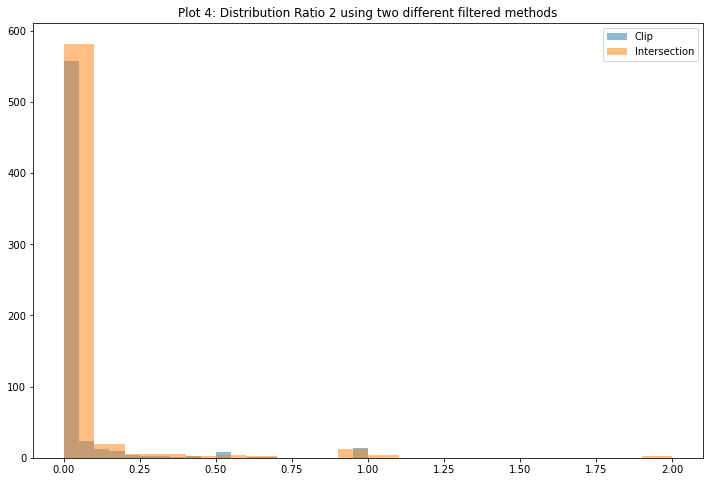

In [105]:
plt.figure(figsize=(12,8))
plt.hist(df2['DistRatio2'],bins=20, alpha=0.5, label = 'Clip')
plt.hist(df['DistRatio2'],bins=20, alpha=0.5, label = 'Intersection')
plt.legend()
plt.title('Plot 4: Distribution Ratio 2 using two different filtered methods')

With the method 1 (Intersection) are species that have: 

$\frac{\text{distribution area within total conservation area}}{\text{total distribution area}} > 1$

and that have not sense in the reality

But, with the method 2 (Clip) that doesn't happen, the maximum value is 1. It's more close to the reality.

Text(0.5, 1.0, 'Plot 5: Distribution Ratio 2 using two different filtered methods')

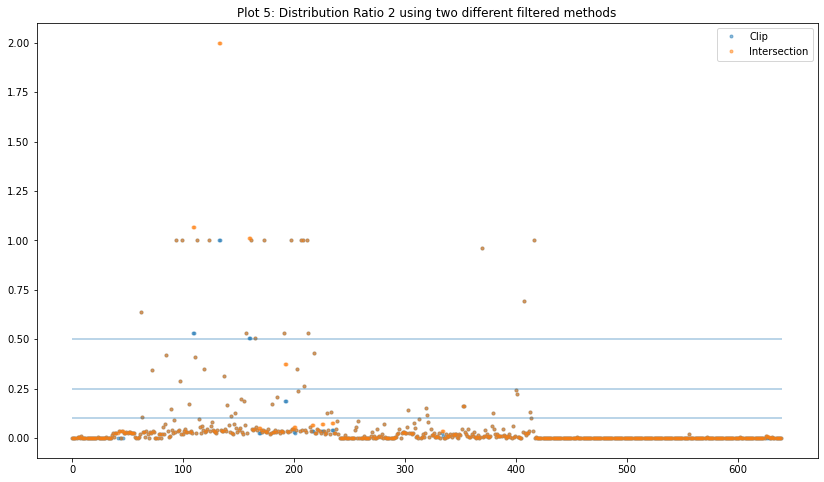

In [123]:
plt.figure(figsize=(14,8))
plt.plot(df2['DistRatio2'],'.', alpha=0.5, label = 'Clip')
plt.plot(df['DistRatio2'],'.', alpha=0.5, label = 'Intersection')
plt.legend()
plt.hlines(y=0.1,xmin=0, xmax=640,alpha=0.4)
plt.hlines(y=0.25,xmin=0, xmax=640,alpha=0.4)
plt.hlines(y=0.5,xmin=0, xmax=640,alpha=0.4)
plt.title('Plot 5: Distribution Ratio 2 using two different filtered methods')

In this plot we can see that:
1. With method 1, the maximum value is 2.
2. With method 2, the maximun value is 1.
3. For both methods, the most of the species has a small distribution ratio 2 [0 - 0.1], it means that the total distribution area is biggest than conservation area (ACMC), so those species could be migratory  or global species.
4. Also, if the species have a distribution ratio 2 between [0.25-0.50], those species could only belong to the Pacific.
5. In addition, if distribution ratio 2 is > 0.50, those species could be considered local.

**Here we have the following issue:**

The result to get distribution area within total conservation area per species depends of the method that we use, in this case was 'intersection' and 'clip'.

The method 2 seems to be more appropriate.

Verify:

1) Maximum ratios

Method 1

In [62]:
print("The species with the highest ratio of conservation area with method 1:")
df[df.DistRatio2==np.max(df.DistRatio2)]

The species with the highest ratio of conservation area with method 1:


,index,ASSESSMENT,ID_NO,BINOMIAL,PRESENCE,ORIGIN,SEASONAL,COMPILER,YEAR,CITATION,...,ISLAND,TAX_COMM,redlistCat,scientific,geometry,area,DistRatio,DistFactorPerc,DistRatio2,DistFactorPerc2
132,808,8112889,183433.0,Halichoeres salmofasciatus,1,1,1,IUCN,2009,International Union for Conservation of Nature...,...,None,None,Vulnerable,Halichoeres salmofasciatus,"POLYGON ((-86.13105 5.59887, -86.12913 5.53945...",2.732157,4.806917,480.691733,2.0,200.0
133,809,8112889,183433.0,Halichoeres salmofasciatus,1,1,1,IUCN,2010,International Union for Conservation of Nature...,...,None,None,Vulnerable,Halichoeres salmofasciatus,"POLYGON ((-86.13105 5.59887, -86.12913 5.53945...",2.732157,4.806917,480.691733,2.0,200.0


Let's see what species have `DistRatio2 >= 1` in df

In [63]:
for x in range(len(df)):
    if df.DistRatio2[x] >= 1:
        print('The species is: '+str(df.BINOMIAL[x]))
        print('with DistRatio2: '+str(df.DistRatio2[x]))

The species is: Xyrichtys victori
with DistRatio2: 1.0661271749386128
The species is: Xyrichtys victori
with DistRatio2: 1.0661271749386128
The species is: Halichoeres salmofasciatus
with DistRatio2: 2.0
The species is: Halichoeres salmofasciatus
with DistRatio2: 2.0
The species is: Halichoeres discolor
with DistRatio2: 1.0143868688681699
The species is: Halichoeres discolor
with DistRatio2: 1.0143868688681699
The species is: Ogilbia cocoensis
with DistRatio2: 1.0000000000000009
The species is: Gobiesox woodsi
with DistRatio2: 1.0
The species is: Sicydium cocoense
with DistRatio2: 1.0000000000000002


Method 2

In [64]:
print("The species with the highest ratio of conservation area with method 2:")
df2[df2.DistRatio2==np.max(df2.DistRatio2)]

The species with the highest ratio of conservation area with method 2:


,index,ASSESSMENT,ID_NO,BINOMIAL,PRESENCE,ORIGIN,SEASONAL,COMPILER,YEAR,CITATION,...,ISLAND,TAX_COMM,redlistCat,scientific,geometry,area,DistRatio,DistFactorPerc,DistRatio2,DistFactorPerc2
173,970,8151020,183647.0,Ogilbia cocoensis,1,1,1,IUCN,2010,International Union for Conservation of Nature...,...,None,None,Vulnerable,Ogilbia cocoensis,"POLYGON ((-86.12913 5.53945, -86.12950 5.51332...",2.732156,4.806918,480.691827,1.0,100.0


Let's see what species have `DistRatio2 >= 1` in df2

In [65]:
for x in range(len(df2)):
    if df2.DistRatio2[x] >= 1:
        print('The species is: '+str(df2.BINOMIAL[x]))
        print('with DistRatio2: '+str(df2.DistRatio2[x]))

The species is: Halichoeres salmofasciatus
with DistRatio2: 1.0
The species is: Halichoeres salmofasciatus
with DistRatio2: 1.0
The species is: Ogilbia cocoensis
with DistRatio2: 1.0000000000000009
The species is: Gobiesox woodsi
with DistRatio2: 1.0
The species is: Sicydium cocoense
with DistRatio2: 1.0000000000000002


2) Minimun ratios

Method 1

In [67]:
print("The species with the lowest ratio of conservation area:distribution area is:")
df[df.DistRatio2==np.min(df.DistRatio2)]

The species with the lowest ratio of conservation area:distribution area is:


,index,ASSESSMENT,ID_NO,BINOMIAL,PRESENCE,ORIGIN,SEASONAL,COMPILER,YEAR,CITATION,...,ISLAND,TAX_COMM,redlistCat,scientific,geometry,area,DistRatio,DistFactorPerc,DistRatio2,DistFactorPerc2
312,1982,115223819,154698.0,Lophodolos indicus,1,1,1,SRLI,2010,Sampled Red List Index,...,None,None,Least Concern,Lophodolos indicus,"MULTIPOLYGON (((-107.15026 20.06524, -106.5514...",8497.786124,0.001545,0.154549,0.000008,0.000845


In [68]:
print("The species with the lowest ratio of conservation area:distribution area is:")
df[df.DistRatio2==np.min(df.DistRatio2)]

The species with the lowest ratio of conservation area:distribution area is:


,index,ASSESSMENT,ID_NO,BINOMIAL,PRESENCE,ORIGIN,SEASONAL,COMPILER,YEAR,CITATION,...,ISLAND,TAX_COMM,redlistCat,scientific,geometry,area,DistRatio,DistFactorPerc,DistRatio2,DistFactorPerc2
312,1982,115223819,154698.0,Lophodolos indicus,1,1,1,SRLI,2010,Sampled Red List Index,...,None,None,Least Concern,Lophodolos indicus,"MULTIPOLYGON (((-107.15026 20.06524, -106.5514...",8497.786124,0.001545,0.154549,0.000008,0.000845


Method 2

In [69]:
print("The species with the smallest ratio of conservation area:")
df2[df2.DistRatio2==np.min(df2.DistRatio2)]

The species with the smallest ratio of conservation area:


,index,ASSESSMENT,ID_NO,BINOMIAL,PRESENCE,ORIGIN,SEASONAL,COMPILER,YEAR,CITATION,...,ISLAND,TAX_COMM,redlistCat,scientific,geometry,area,DistRatio,DistFactorPerc,DistRatio2,DistFactorPerc2
312,1982,115223819,154698.0,Lophodolos indicus,1,1,1,SRLI,2010,Sampled Red List Index,...,None,None,Least Concern,Lophodolos indicus,"POLYGON ((-88.94648 6.53217, -89.32126 6.23234...",8497.786124,0.001545,0.154549,0.000008,0.000845


In this case, it has the same species with the smallest ratio of conservation area

Comparing..

In [73]:
print("Species distratio2, v1:")
print(df[df.ID_NO==183433.0].DistRatio2)
print(df[df.ID_NO==183433.0].BINOMIAL)
print("Species distratio2, v2:")
print(df2[df2.ID_NO==183433.0].DistRatio2)
print(df2[df2.ID_NO==183433.0].BINOMIAL)

Species distratio2, v1:
132    2.0
133    2.0
Name: DistRatio2, dtype: float64
132    Halichoeres salmofasciatus
133    Halichoeres salmofasciatus
Name: BINOMIAL, dtype: object
Species distratio2, v2:
132    1.0
133    1.0
Name: DistRatio2, dtype: float64
132    Halichoeres salmofasciatus
133    Halichoeres salmofasciatus
Name: BINOMIAL, dtype: object


In [74]:
print("Species distratio2, v1:")
print(df[df.ID_NO==60324.0].DistRatio2)
print(df[df.ID_NO==60324.0].BINOMIAL)
print("Species distratio2, v2:")
print(df2[df2.ID_NO==60324.0].DistRatio2)
print(df2[df2.ID_NO==60324.0].BINOMIAL)

Species distratio2, v1:
467    0.00001
Name: DistRatio2, dtype: float64
467    Chanos chanos
Name: BINOMIAL, dtype: object
Species distratio2, v2:
467    0.00001
Name: DistRatio2, dtype: float64
467    Chanos chanos
Name: BINOMIAL, dtype: object


In [75]:
print("Species distratio2, v1:")
print(df[df.ID_NO==39375.0].DistRatio2)
print(df[df.ID_NO==39375.0].BINOMIAL)
print("Species distratio2, v2:")
print(df2[df2.ID_NO==39375.0].DistRatio2)
print(df2[df2.ID_NO==39375.0].BINOMIAL)

Species distratio2, v1:
280    0.000009
Name: DistRatio2, dtype: float64
280    Carcharhinus melanopterus
Name: BINOMIAL, dtype: object
Species distratio2, v2:
280    0.000009
Name: DistRatio2, dtype: float64
280    Carcharhinus melanopterus
Name: BINOMIAL, dtype: object


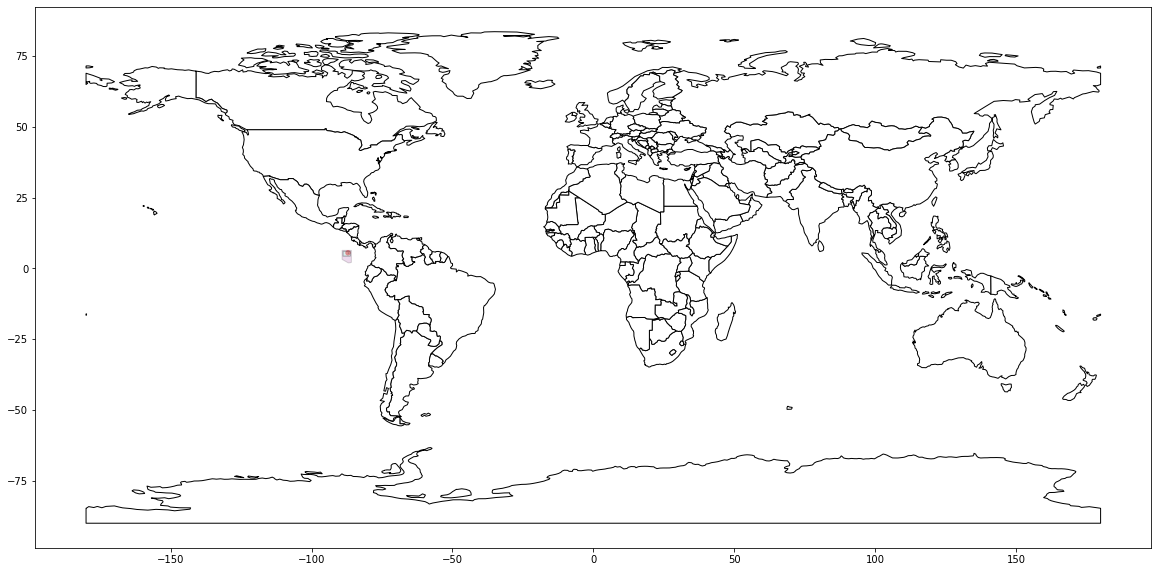

In [76]:
world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))
fig, ax = plt.subplots(figsize=(20,10))

ax.set_aspect('equal')

world.plot(ax=ax, color='white', edgecolor='black')


# ax.scatter(Cocos.x, Cocos.y, c = 'r')
df[df.DistRatio2==np.max(df.DistRatio2)].plot(ax = ax, color = 'r', alpha = 0.25)

AMMB_WGS84.plot(ax=ax, alpha = 0.15, color = 'purple', edgecolor='black')

PNIC_WGS84.plot(ax=ax, alpha = 0.15, color = 'teal', edgecolor='black')#, marker='o', color='red', markersize=5)

#ax.set_xlim((-110, -60))
#ax.set_ylim((-50, 60))
plt.show();

Let's see more close to ACMC:

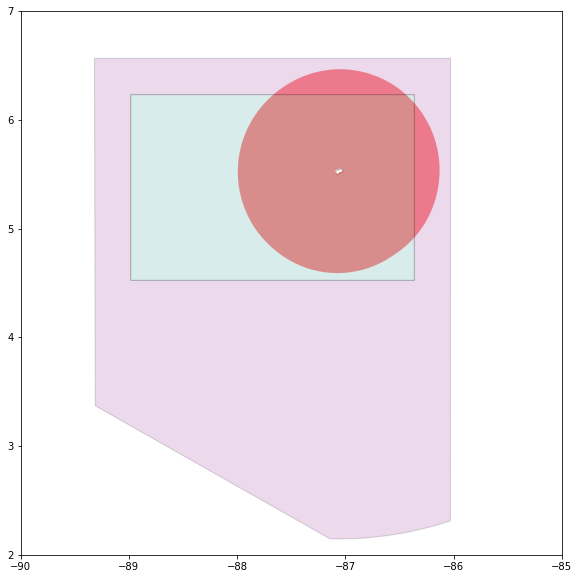

In [77]:
world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))
fig, ax = plt.subplots(figsize=(20,10))

ax.set_aspect('equal')

world.plot(ax=ax, color='white', edgecolor='black')


# ax.scatter(Cocos.x, Cocos.y, c = 'r')
df[df.DistRatio2==np.max(df.DistRatio2)].plot(ax = ax, color = 'r', alpha = 0.25)

AMMB_WGS84.plot(ax=ax, alpha = 0.15, color = 'purple', edgecolor='black')

PNIC_WGS84.plot(ax=ax, alpha = 0.15, color = 'teal', edgecolor='black')#, marker='o', color='red', markersize=5)

ax.set_xlim((-90, -85))
ax.set_ylim((2, 7))
plt.show();

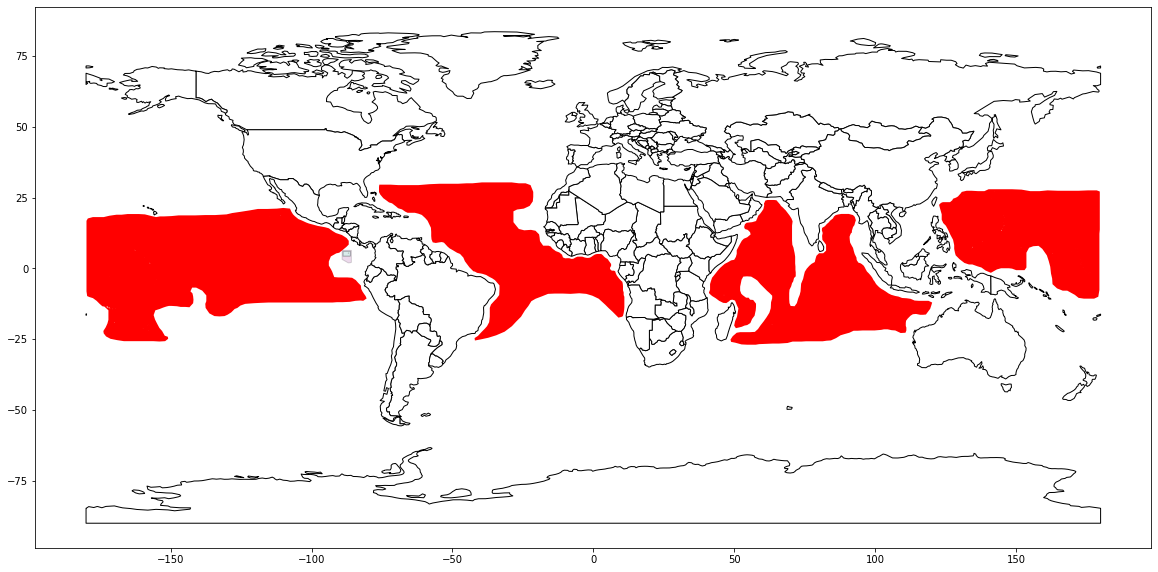

In [78]:
world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))
fig, ax = plt.subplots(figsize=(20,10))

ax.set_aspect('equal')

world.plot(ax=ax, color='white', edgecolor='black')


# ax.scatter(Cocos.x, Cocos.y, c = 'r')
df[df.DistRatio2==np.min(df.DistRatio2)].plot(ax = ax, color = 'r', alpha = 1)

AMMB_WGS84.plot(ax=ax, alpha = 0.15, color = 'purple', edgecolor='black')

PNIC_WGS84.plot(ax=ax, alpha = 0.15, color = 'teal', edgecolor='black')#, marker='o', color='red', markersize=5)


#ax.set_xlim((-90, -80))
#ax.set_ylim((0, 10))
plt.show();

Let's see more close to ACMC:

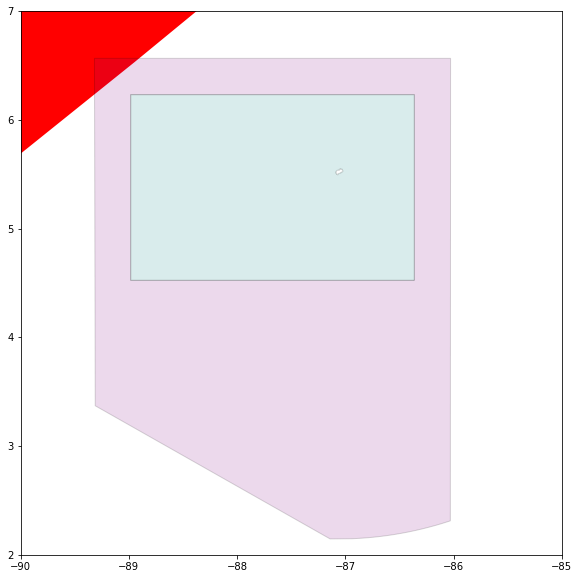

In [79]:
world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))
fig, ax = plt.subplots(figsize=(20,10))

ax.set_aspect('equal')

world.plot(ax=ax, color='white', edgecolor='black')


# ax.scatter(Cocos.x, Cocos.y, c = 'r')
df[df.DistRatio2==np.min(df.DistRatio2)].plot(ax = ax, color = 'r', alpha = 1)

AMMB_WGS84.plot(ax=ax, alpha = 0.15, color = 'purple', edgecolor='black')

PNIC_WGS84.plot(ax=ax, alpha = 0.15, color = 'teal', edgecolor='black')#, marker='o', color='red', markersize=5)

ax.set_xlim((-90, -85))
ax.set_ylim((2, 7))
plt.show();

We need some post-processing, e.g. smoothing, clustering, etc.

In [ ]:
def get_DistRatioFactor_invsquare(DistRatio, print_out = False):
    # This function calculates the weighted endemism of species by taking the sum of the 
    # squares of the ratios of (area conserved / total distribution area)
    #
    # Input arguments:
    #      DistRatio: a series of the area conserved / total distribution area ratio for each species
    #      print_out: a boolean for printing out the factor
    #
    # Output:
    #      factor: the factor of weighted endemism
    
    factor = 1+sum(DistRatio**2)
    if print_out:
        print("We multiply N credits by " + "{:0.3f}".format(factor))
    return factor

What are the credits based on DistRatio2?

In [ ]:
example_credits(area_of_conservation.area, df_nonan.DistRatio2, get_DistRatioFactor);
example_credits(111.1**(-2), df_nonan.DistRatio2, get_DistRatioFactor);

example_credits(area_of_conservation.area, df_nonan.DistRatio2, get_DistRatioFactor_square);
example_credits(111.1**(-2), df_nonan.DistRatio2, get_DistRatioFactor_square);

Okay for the order of magnitude, so-so for what it represents.

Wild card:

In [ ]:
example_credits(area_of_conservation.area, df_nonan.DistRatio, get_DistRatioFactor_invsquare);
example_credits(111.1**(-2), df_nonan.DistRatio, get_DistRatioFactor);

We will need to check this out with "smoothing".

... to be continued.

It seems like a fairer approach.